In [1]:
import numpy as np
from pathlib import Path
import h5py
import pandas as pd
import awkward as ak

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special, interpolate


def background_cdf_awk(x, n_signal, n_sample, var):
    
    N = n_sample - ak.to_numpy(n_signal)
    
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N[:, np.newaxis])

def cdf_from_pdf(x, pdf):
    
    cdf = np.zeros((pdf.shape[0], x.size))
    for i in range(x.size):
        
        cdf[:, i] = np.trapz(pdf[:, 0:i+1], x[0:i+1], axis=-1)
        
    return cdf

def combine_batch_cdf(cdf, counts):
    
    count = 0
    cdf_ak = []
    for n in counts:
        cdf_ak.append(cdf[count:count+n, :])
        count+=n
    cdf_ak = ak.Array(cdf_ak)
        
    return ak.to_numpy(ak.prod(cdf_ak, axis=1))

def background_cdf(x, N, var):
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N)

def rician_pdf(x, var, loc_val):
    
    x = x[np.newaxis, :]
    loc_val = loc_val[:, np.newaxis]
    
    return x * np.exp( -1 * (x ** 2 + loc_val ** 2) / var ) * special.iv(0, x * 2 * loc_val / var)

def get_spectra_peaks(freq_spectra, threshold):
    
    peaks = []
    for i in range(freq_spectra.shape[0]):
        i_peak_inds = np.where(abs(freq_spectra[i, :]) > threshold)[0]
        i_peaks = abs(freq_spectra[i, i_peak_inds])

        peaks.append(list(i_peaks))
    
    return ak.Array(peaks)

def generate_signal_cdf(peaks, x, var, n_sample, batchsize=1000):
    
    peak_counts = ak.num(peaks, axis=1)
    num_spectra = ak.num(peaks, axis=0)
    
    spectra_inds = np.arange(0, num_spectra, 1)
    combined_cdf = np.zeros((num_spectra, x.size))
    
    for i, spectra_batch in enumerate(np.array_split(spectra_inds, num_spectra//batchsize)):
        
        batch_peaks = peaks[spectra_batch]
        batch_counts = ak.num(batch_peaks, axis=1)
        flat_batch_peaks = ak.to_numpy(ak.flatten(batch_peaks))
        
        batch_pdf = rician_pdf(x, var, flat_batch_peaks)
        batch_norm = 1/np.trapz(batch_pdf, x, axis=-1)
        batch_pdf = batch_norm[:, np.newaxis] * batch_pdf
        
        batch_cdf = cdf_from_pdf(x, batch_pdf)
        batch_cdf = combine_batch_cdf(batch_cdf, batch_counts)

        combined_cdf[spectra_batch, :] = batch_cdf * background_cdf_awk(x, batch_counts, n_sample, var)
        
        if i % 5 == 4:
            print(f'{i + 1} / {num_spectra//batchsize}')
            
    return combined_cdf

def get_FFT_spectra(pitch,):
    
    path2signals = Path.home()/'group'/'project'/'datasets'/'data'
    file = '220901_dl_test_data_85to90deg_5mm.h5'

    h5file = h5py.File(path2signals/file, 'r')

    metadata = {
        'energy':h5file['meta']['energy'][:],
        'pitch':h5file['meta']['theta_min'][:],
        'radius':h5file['meta']['x_min'][:]
    }

    metadata = pd.DataFrame(metadata)

    inds = np.array(metadata[
        (abs(metadata['pitch']-pitch)<0.0005)
    ].index.array)
    

    signal_freq_spectra = np.fft.fftshift(np.fft.fft(
        h5file['x'][inds, 0:8192], axis=-1, norm='forward'))
    
    return signal_freq_spectra


def estimate_mean_FFT(min_pitch = 86.0, max_pitch = 88.6, n_pts=101):
    
    path2signals = Path.home()/'group'/'project'/'datasets'/'data'
    file = '220901_dl_test_data_85to90deg_5mm.h5'

    pitch_min=min_pitch
    pitch_max=max_pitch
    radius_min=0.005
    radius_max=0.005

    h5file = h5py.File(path2signals/file, 'r')

    metadata = {
        'energy':h5file['meta']['energy'][:],
        'pitch':h5file['meta']['theta_min'][:],
        'radius':h5file['meta']['x_min'][:]
    }

    metadata = pd.DataFrame(metadata)

    inds = np.array(metadata[
        (metadata['pitch']>=pitch_min)&(metadata['pitch']<=pitch_max)
        & (metadata['radius']>=radius_min)&(metadata['radius']<=radius_max)
    ].index.array)
    
    pitch_angles = np.array(metadata['pitch'].iloc[inds].array)

    signal_freq_spectra = np.fft.fftshift(np.fft.fft(
        h5file['x'][inds, 0:8192], axis=-1, norm='forward'))
    
    nonzero_inds = np.argwhere(abs(signal_freq_spectra).sum(-1)>0).squeeze()
    signal_freq_spectra = signal_freq_spectra[nonzero_inds, :]
    pitch_angles = pitch_angles[nonzero_inds]
    
    peak_threshold = 1e-8
    system_noise_temp = 10
    n_sample = 8192
    noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
    n_pts_dist = n_pts
    x = np.linspace(0, 1e-6, n_pts_dist)

    peaks = get_spectra_peaks(signal_freq_spectra, peak_threshold)
    cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample, batchsize=256)
    
    pdf = np.gradient(cdf, axis=-1)
    norm = 1/np.trapz(pdf, x)
    pdf = norm[:, np.newaxis] * pdf
    
    return cdf, pdf

def estimate_FFT(pitch, n_pts=101):
    
    path2signals = Path.home()/'group'/'project'/'datasets'/'data'
    file = '220901_dl_test_data_85to90deg_5mm.h5'

    h5file = h5py.File(path2signals/file, 'r')

    metadata = {
        'energy':h5file['meta']['energy'][:],
        'pitch':h5file['meta']['theta_min'][:],
        'radius':h5file['meta']['x_min'][:]
    }

    metadata = pd.DataFrame(metadata)

    inds = np.array(metadata[
        (abs(metadata['pitch']-pitch)<0.0005)
    ].index.array)
    

    signal_freq_spectra = np.fft.fftshift(np.fft.fft(
        h5file['x'][inds, 0:8192], axis=-1, norm='forward'))
    
    nonzero_inds = np.argwhere(abs(signal_freq_spectra).sum(-1)>0).squeeze()
    signal_freq_spectra = signal_freq_spectra[nonzero_inds, :]
    #print(signal_freq_spectra.shape)
    signal_freq_spectra = signal_freq_spectra[0]
    #print(signal_freq_spectra.shape)
    
    peak_threshold = 1e-8
    system_noise_temp = 10
    n_sample = 8192
    noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
    n_pts_dist = n_pts
    x = np.linspace(0, 1e-6, n_pts_dist)
    
    peaks = get_spectra_peaks(signal_freq_spectra[np.newaxis, :], peak_threshold)
    cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample, batchsize=1)
    
    pdf = np.gradient(cdf, axis=-1)
    norm = 1/np.trapz(pdf, x)
    pdf = norm[:, np.newaxis] * pdf

    #peaks = np.where(abs(signal_freq_spectra) > peak_threshold)[0]
    
    #pdf = rician_pdf(x, noise_variance, abs(signal_freq_spectra[peaks]))
    #pdf = np.prod(pdf, axis=0)
    #norm_pdf = 1 / np.trapz(pdf, x, axis=-1)
    #pdf = norm_pdf[:, np.newaxis] * pdf
    #pdf = norm_pdf * pdf
    
    #cdf = cdf_from_pdf(x, pdf)
    #cdf = np.prod(cdf, axis=0)
    #pdf = np.prod(pdf, axis=0)
    
    #cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample)
    
    #pdf = np.gradient(cdf, axis=-1)
    #norm = 1/np.trapz(pdf, x)
    #pdf = norm[:, np.newaxis] * pdf
    
    return cdf, pdf

# ROC by pitch

In [2]:
system_noise_temp = 10
n_pts_dist = 151
n_sample = 8192
noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
x = np.linspace(0, 1e-6, n_pts_dist)
min_pitch = 85.5
max_pitch = 88.5

fft_cdf_background = background_cdf(x, n_sample, noise_variance)
fft_pdf_background = np.gradient(fft_cdf_background) / np.trapz(np.gradient(fft_cdf_background), x)

fft_cdf_mean, fft_pdf_mean = estimate_mean_FFT(min_pitch=min_pitch, max_pitch=max_pitch, n_pts=n_pts_dist)




5 / 97
10 / 97
15 / 97
20 / 97
25 / 97
30 / 97
35 / 97
40 / 97
45 / 97
50 / 97
55 / 97
60 / 97
65 / 97
70 / 97
75 / 97
80 / 97
85 / 97
90 / 97
95 / 97


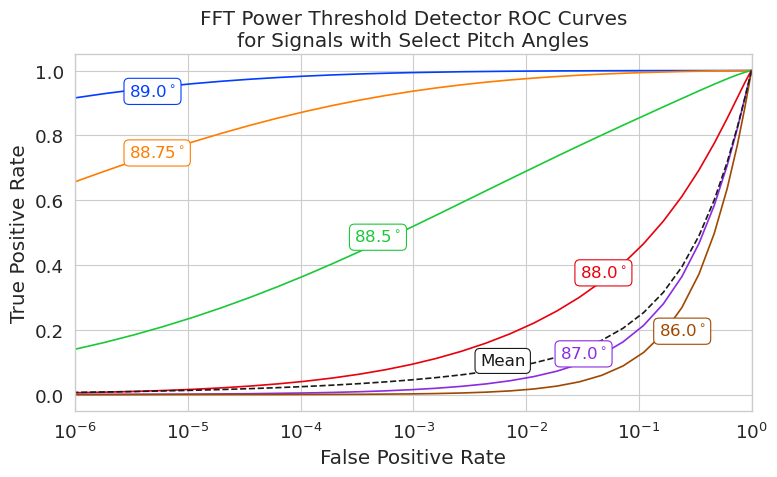

In [3]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

system_noise_temp = 10
n_pts_dist = 151
n_sample = 8192
noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
x = np.linspace(0, 1e-6, n_pts_dist)

pitch_list = [89,88.75,88.5, 88, 87, 86, ]
pitch_labels = [89.0,88.75,88.5, 88.0, 87.0, 86.0, 85.0]

auc_text_loc = [(3e-6,0.92),(3e-6,0.73),(3e-4,0.47),(3e-2, 0.36),(2e-2,0.11),(1.5e-1, 0.18)]
clist = sns.color_palette('bright', n_colors=7)
for i, pitch in enumerate(pitch_list):
    temp_cdf, temp_pdf, = estimate_FFT(pitch, n_pts=n_pts_dist)
    auc = round(abs(np.trapz(1-temp_cdf.squeeze(), 1-fft_cdf_background)),4)
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        1-fft_cdf_background,
        1-temp_cdf.squeeze(),
        label=rf'{pitch_labels[i]}$^\circ$',
        color=clist[i],
    )
    ax.text(
        auc_text_loc[i][0],
        auc_text_loc[i][1],
        rf'{pitch_labels[i]}$^\circ$',
        size=12,
        color=clist[i],
        bbox=props
    )
    
auc = round(abs(np.trapz(1-fft_cdf_mean.mean(axis=0), 1-fft_cdf_background)),2)
line_mean, = ax.plot(1-fft_cdf_background, 1-fft_cdf_mean.mean(axis=0), ls='--', color='k',)
props = dict(boxstyle='round', facecolor='white', edgecolor='k')
ax.text(3.9e-3, 0.09, 'Mean', size=12, color='k', bbox=props)

#ax.set_xscale('log')
#ax.set_xlim(1e-6, 1)
#legend2 = ax.legend([line_mean], [f'AUC={0.64}'], loc=(1.01,0.05), title='Mean Signal')
#ax.legend(loc=9,ncol=2, title='Pitch Angle')
#plt.gca().add_artist(legend2)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('FFT Power Threshold Detector ROC Curves'+'\n'+'for Signals with Select Pitch Angles')
ax.set_xscale('log')
ax.set_xlim(1e-6,1)
plt.tight_layout(pad=1.05)
#plt.savefig(Path.home()/'group'/'project'/'plots'/'230313_fft_power_threshold_roc_by_pitch_log', dpi=144)




# pdf

In [4]:
# build interpolator functions to make the plot nicer
x_interp = np.linspace(0, 1e-6, 501)
x_mean = np.linspace(0,1e-6, 151)
interp_mean = interpolate.interp1d(x_mean, fft_pdf_mean.mean(axis=0), kind='cubic')



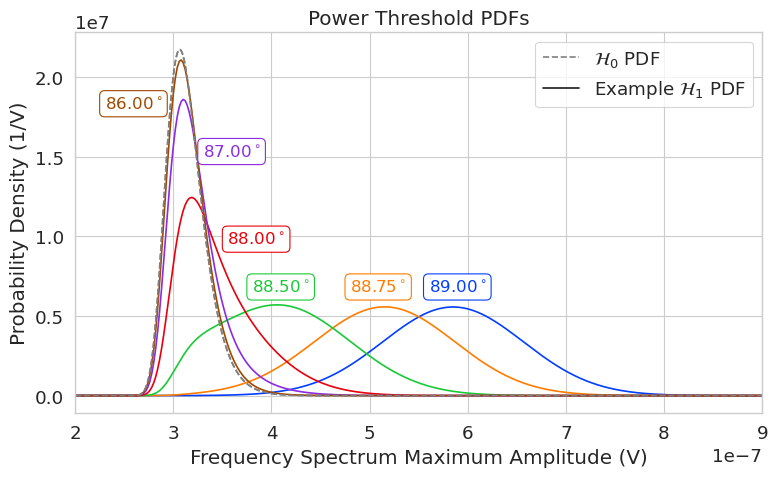

In [6]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

x_back = np.linspace(0,1e-6, 1001)
x_mean = np.linspace(0,1e-6, 151)
x_example = np.linspace(0,1e-6, 501)
fft_cdf_background = background_cdf(x_back, n_sample, noise_variance)
fft_pdf_background = np.gradient(fft_cdf_background) / np.trapz(np.gradient(fft_cdf_background), x_back)

line_b, = ax.plot(x_back,fft_pdf_background, marker = 'None', color='grey',ls='--')
line_ex, = ax.plot([],[],marker='None', color='k',ls='-',)


#clist = sns.color_palette('deep', n_colors=6)
clist = sns.color_palette('bright', n_colors=7)
auc_text_loc = [(5.6e-7,0.65e7),(4.8e-7,0.65e7),(3.8e-7,0.65e7),(3.55e-7, 0.95e7),(3.3e-7,1.5e7),(2.3e-7, 1.8e7)]
for i, pitch in enumerate([89, 88.75, 88.5, 88.0, 87.0, 86.0,]):
    temp_cdf, temp_pdf, = estimate_FFT(pitch, n_pts = 501)
    #auc = round(abs(np.trapz(1-cdf*cdf_background, 1-cdf_background)),2)
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        x_example,
        temp_pdf.squeeze(),
        marker='None',
        label=rf'{pitch:.2f}$^\circ$',
        color=clist[i]
    )
    ax.text(
        auc_text_loc[i][0],
        auc_text_loc[i][1],
        rf'{pitch:.2f}$^\circ$',
        color=clist[i],
        size=12,
        bbox=props,
    )
    
line_b, = ax.plot(x_back,fft_pdf_background, marker = 'None', color='grey',ls='--')
ax.set_title('Power Threshold PDFs')

ax.set_xlim(2e-7, 0.9e-6)
ax.set_ylabel('Probability Density (1/V)')
ax.set_xlabel('Frequency Spectrum Maximum Amplitude (V)')
plt.tight_layout(pad=1.05)
#legend1 = plt.legend(loc=1, title='Signal PDF'+'\n'+'Pitch Angle')
legend2 = plt.legend([line_b, line_ex],[r'$\mathcal{H}_0$ PDF', r'Example $\mathcal{H}_1$ PDF'], loc=1, )
#plt.gca().add_artist(legend1)

plt.savefig(Path.home()/'group'/'project'/'plots'/'230915_fft_power_threshold_pdf_by_pitch', dpi=144)





# cdf

In [78]:
# build interpolator functions to make the plot nicer
x_interp = np.linspace(0, 1e-6, 1001)
x_mean = np.linspace(0,1e-6, 151)
fft_interp_mean_cdf = interpolate.interp1d(x_mean, fft_cdf_mean.mean(axis=0), kind='cubic')


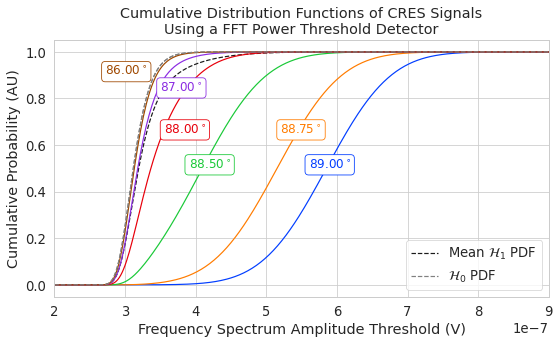

In [95]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

x_back = np.linspace(0,1e-6, 1001)
x_mean = np.linspace(0,1e-6, 151)
x_example = np.linspace(0,1e-6, 501)
fft_cdf_background = background_cdf(x_back, n_sample, noise_variance)
fft_pdf_background = np.gradient(fft_cdf_background) / np.trapz(np.gradient(fft_cdf_background), x_back)

line_b, = ax.plot(x_back,fft_cdf_background, marker = 'None', color='grey',ls='--')
line_m, = ax.plot(x_interp,fft_interp_mean_cdf(x_interp),marker='None', color='k',ls='--',)


#clist = sns.color_palette('deep', n_colors=6)
clist = sns.color_palette('bright', n_colors=7)
auc_text_loc = [(5.6e-7,0.5),(5.2e-7,0.65),(3.9e-7,0.5),(3.55e-7, 0.65),(3.5e-7,0.83),(2.72e-7, .9)]
for i, pitch in enumerate([89, 88.75, 88.5, 88.0, 87.0,86.0,]):
    temp_cdf, temp_pdf, = estimate_FFT(pitch, n_pts = 501)
    #auc = round(abs(np.trapz(1-cdf*cdf_background, 1-cdf_background)),2)
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        x_example,
        temp_cdf.squeeze(),
        marker='None',
        label=rf'{pitch:.2f}$^\circ$',
        color=clist[i]
    )
    ax.text(
        auc_text_loc[i][0],
        auc_text_loc[i][1],
        rf'{pitch:.2f}$^\circ$',
        color=clist[i],
        size=12,
        bbox=props,
    )
    
line_b, = ax.plot(x_back,fft_cdf_background, marker = 'None', color='grey',ls='--')
ax.set_title('Cumulative Distribution Functions of CRES Signals'+'\n'+'Using a FFT Power Threshold Detector')

ax.set_xlim(2e-7, 0.9e-6)
ax.set_ylabel('Cumulative Probability (AU)')
ax.set_xlabel('Frequency Spectrum Amplitude Threshold (V)')
plt.tight_layout(pad=1.05)
#legend1 = plt.legend(loc=5, title='Signal CDF'+'\n'+'Pitch Angle')
legend2 = plt.legend([line_m, line_b],[r'Mean $\mathcal{H}_1$ PDF', r'$\mathcal{H}_0$ PDF'], loc=4, )
#plt.gca().add_artist(legend1)

plt.savefig(Path.home()/'group'/'project'/'plots'/'230313_fft_power_threshold_cdf_by_pitch', dpi=144)




# spectra

# spectrum compare

8.257592683368824e-11
-21.29863226876428
-23.317758916805126
-24.963010320536384
-26.21740157989922
-27.891091261611653
-29.21193148928473
-31.027982662049183


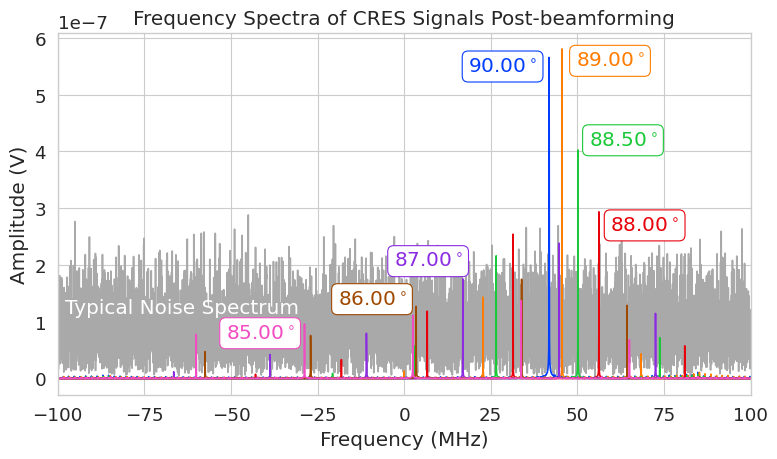

In [16]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)


clist = sns.color_palette('bright', n_colors=10)

freqs = np.fft.fftshift(np.fft.fftfreq(8192, 1/200e6))
rng = np.random.default_rng()
var = 10 * 1.38e-23 * 50 * 200e6 * 60 / 8192
noise_fft = rng.multivariate_normal([0,0], np.eye(2) * var/2, 8192)
noise_fft = noise_fft[:,0] + noise_fft[:, 1]*1j

print(np.sum(abs(noise_fft**2)))

noise_time = rng.multivariate_normal([0,0], np.eye(2) * var*8192/2, 8192)
noise_time = noise_time[:,0] + noise_time[:, 1]*1j

line_noise, = ax.plot(freqs*1e-6, abs(noise_fft),color='darkgrey')

text_coords = [(18.5,5.4e-7),(49.5,5.5e-7),(53.25,4.1e-7),(59.5, 2.6e-7),(-3,1.97e-7),(-19.2,1.3e-7),(-51.5,0.7e-7)]


for i, pitch in enumerate([90,89,88.5,88,87,86,85]):
    f_spectra = get_FFT_spectra(pitch,)[0]

    ax.plot(
        freqs*1e-6,
        abs(f_spectra) / 1,
        marker='None',
        label=rf'{pitch:.2f}$^\circ$',
        color=clist[i],
    )
    print(10*np.log10(np.sum(abs(f_spectra**2)) / np.sum(abs(noise_fft**2))))
    
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.text(
        text_coords[i][0],
        text_coords[i][1],
        rf'{pitch:.2f}$^\circ$',
        color=clist[i],
        bbox=props,
    )
    
    
    
ax.text(-98, 1.15e-7, 'Typical Noise Spectrum', color='white')
ax.set_xlim(-100, 100)
#legend1 = ax2.legend(loc=(0.01, 0.8))
#legend2 = ax2.legend([line_noise], ['Typical Noise Spectrum'], loc=(0.01, 0.9))
#plt.legend(loc=2, title='Signal Spectrum'+'\n'+'Pitch Angle')
#plt.gca().add_artist(legend1)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (V)')
ax.set_title('Frequency Spectra of CRES Signals Post-beamforming')

#ax1.set_xlabel('Time (s)')
#ax1.set_ylabel('Amplitude (V)')
#ax1.set_title('Time Series of a CRES Signal Post-beamforming')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230927_cres_signal_post_bf_examples', dpi=150) 

# time series and spectrum

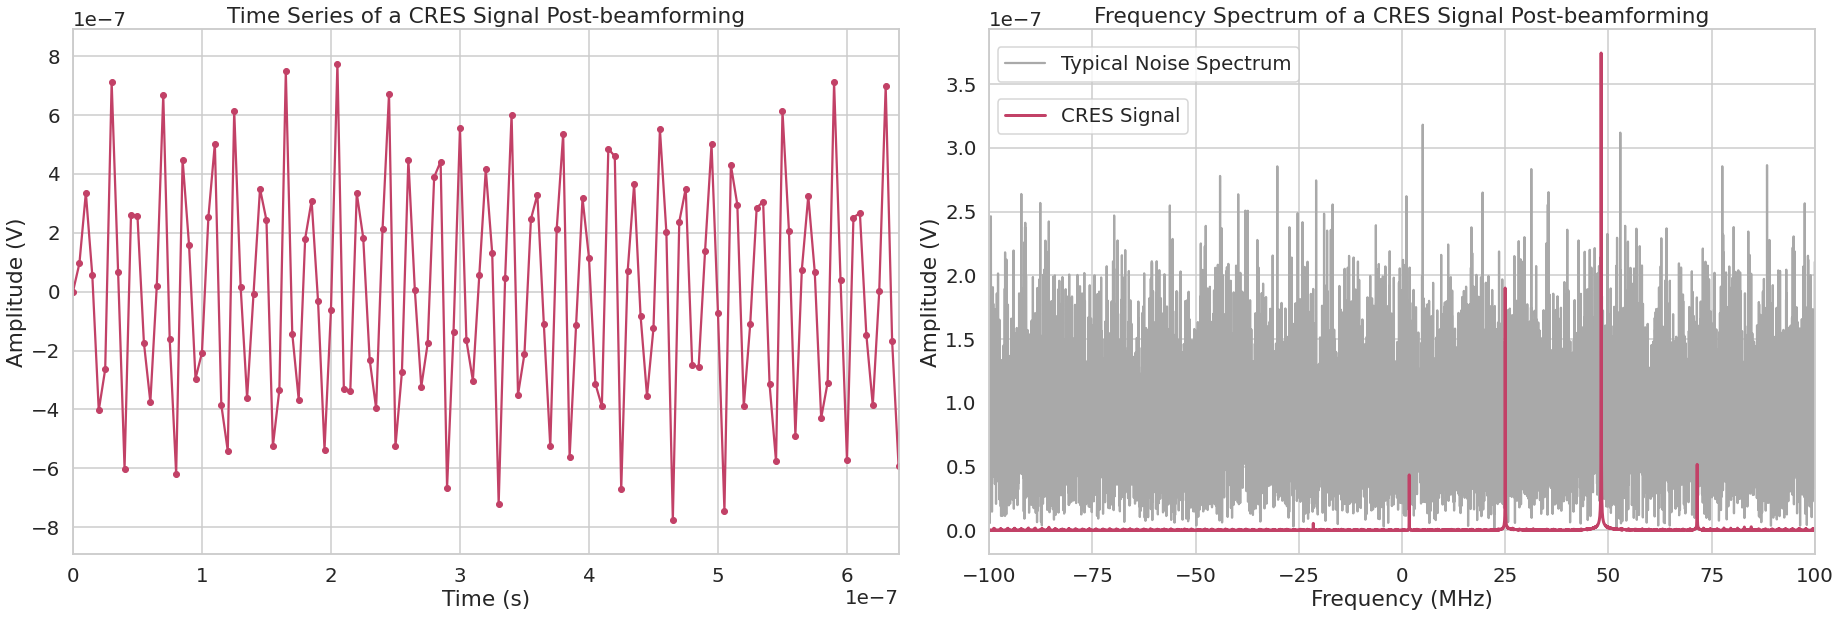

In [66]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(26,9))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

clist = sns.color_palette('flare_r', n_colors=1)

freqs = np.fft.fftshift(np.fft.fftfreq(8192, 1/200e6))
rng = np.random.default_rng()
var = 10 * 1.38e-23 * 50 * 200e6 * 60 / 8192
noise_fft = rng.multivariate_normal([0,0], np.eye(2) * var/2, 8192)
noise_fft = noise_fft[:,0] + noise_fft[:, 1]*1j

noise_time = rng.multivariate_normal([0,0], np.eye(2) * var*8192/2, 8192)
noise_time = noise_time[:,0] + noise_time[:, 1]*1j

line_noise, = ax2.plot(freqs*1e-6, abs(noise),color='darkgrey')

#ax1.plot(np.arange(0,freqs.size, 1)/200e6, noise_time.real, color='darkgrey')


for i, pitch in enumerate([88.7,]):
    f_spectra = get_FFT_spectra(pitch,)[0]
    ax1.plot(
        np.arange(0,f_spectra.size, 1)/200e6,
        np.fft.ifft(f_spectra, norm='forward').real / 1,
        marker='.',
        markersize=12,
        label=rf'{pitch:.2f}$^\circ$',
        color=clist[i]
    )
    ax2.plot(
        freqs*1e-6,
        abs(f_spectra) / 1,
        marker='None',
        label=rf'CRES Signal',
        color=clist[i],
        lw=3
    )
    
#ax2.plot(freqs*1e-6, np.sqrt(var)*np.ones(8192),color='k', lw=3, label='Mean Noise')
ax1.set_xlim(0, 128/200e6)
ax2.set_xlim(-100, 100)
legend1 = ax2.legend(loc=(0.01, 0.8))
legend2 = ax2.legend([line_noise], ['Typical Noise Spectrum'], loc=(0.01, 0.9))
#plt.legend(loc=2, title='Signal Spectrum'+'\n'+'Pitch Angle')
plt.gca().add_artist(legend1)
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Amplitude (V)')
ax2.set_title('Frequency Spectrum of a CRES Signal Post-beamforming')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (V)')
ax1.set_title('Time Series of a CRES Signal Post-beamforming')



plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230216_cres_signal_post_bf_example', dpi=144)  
